# **Exploratory PM2.5 Visualization App**

Author: Rob Hendrickson

This project utilizes the power of Python to explore interpolation methods as they apply to local volatile organic compound (VOC) readings. The data to be used is from the Minneapolis Health Department’s 2016 seasonal neighborhood study. There are often extreme readings nearby rather moderate readings, so Ordinary Kriging interpolation produces unrealistic results.

The data was queried for the most prominent VOCs (Benzene & Naphthalene) and divided by season. A regular grid was made over Minneapolis with 100 x 100m resolution, then the observations were iteratively interpolated using the deterministic Radial Based Function (RBF) method. Reasonable parameters were found and then a user interface was developed to allow for tweaking of the parameters using `ipywidgets`. The results can be compared across seasons using the `interp_all_seasons()` function and/or saved as geotiffs using `Rasterio`. 

**Data Sources:** Jenni Lansing (Minneapolis Health Department) - 2016 Neighborhood Air Quality Study

https://www2.minneapolismn.gov/media/content-assets/www2-documents/government/Air-Quality-Study-Long-Report-.pdf

In [2]:
# Import Packages & Libraries

import os

# Analysis Libraries

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import geopandas as gpd # Spatial Data Manipulation
from scipy import interpolate as interp # # different interpolators
import rasterio # Rasters
from rasterio.transform import Affine

# Visualization Libraries

import matplotlib.pyplot as plt # Basic Plotting
plt.style.use('ggplot') # 
import seaborn as sns # Statistical Plotting
import contextily # Base Map Visualization

# Interaction

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import datetime # Time

# Silence Warnings

import warnings
warnings.filterwarnings('ignore')

# Load Data 

In [33]:
datapath = os.path.join('..', '..', 'Data')

# Boundary - From MetroCouncil 2010 CTU boundaries

path = os.path.join(datapath, 'mpls_boundary.geojson')
mpls = gpd.read_file(path)

# PurpleAir Stations

path = os.path.join(datapath, 'PurpleAir_Stations.geojson')
stations = gpd.read_file(path)
stations['sensor_index'] = stations.sensor_index.astype(int)

# PM2.5 Readings and Daily Summaries - From Purple Air

# Results are in micrograms/meter^3
# Mn Health benchmarks found at: https://www.health.state.mn.us/communities/environment/risk/guidance/air/table.html

path = os.path.join(datapath, 'daily_summaries.csv')
daily_sums = pd.read_csv(path)
daily_sums['date'] = pd.to_datetime(daily_sums.date)

# Spikes

path = os.path.join(datapath, 'all_spikes.csv')
spikes = pd.read_csv(path)
spikes['timestamp'] = pd.to_datetime(spikes.timestamp)

In [69]:
daily_sums.columns

Index(['sensor_index', 'date', 'n_observations', 'pm25_fullDay_mean',
       'pm25_fullDay_min', 'pm25_fullDay_minTime', 'pm25_fullDay_max',
       'pm25_fullDay_maxTime', 'pm25_fullDay_std',
       'pm25_fullDay_minutesAbove12ug', 'pm25_morningRush_mean',
       'pm25_morningRush_min', 'pm25_morningRush_minTime',
       'pm25_morningRush_max', 'pm25_morningRush_maxTime',
       'pm25_morningRush_std', 'pm25_eveningRush_mean', 'pm25_eveningRush_min',
       'pm25_eveningRush_minTime', 'pm25_eveningRush_max',
       'pm25_eveningRush_maxTime', 'pm25_eveningRush_std',
       'pm25_daytimeAmbient_mean', 'pm25_daytimeAmbient_min',
       'pm25_daytimeAmbient_minTime', 'pm25_daytimeAmbient_max',
       'pm25_daytimeAmbient_maxTime', 'pm25_daytimeAmbient_std',
       'pm25_nighttimeAmbient_mean', 'pm25_nighttimeAmbient_min',
       'pm25_nighttimeAmbient_minTime', 'pm25_nighttimeAmbient_max',
       'pm25_nighttimeAmbient_maxTime', 'pm25_nighttimeAmbient_std'],
      dtype='object')

## First Plot

In [34]:
# Dates

first_date = min(daily_sums.date)
last_date = max(daily_sums.date)

datelist = pd.date_range(start = first_date, 
                         end = last_date,
                        normalize = True)

datelist

DatetimeIndex(['2022-06-15', '2022-06-16', '2022-06-17', '2022-06-18',
               '2022-06-19', '2022-06-20', '2022-06-21', '2022-06-22',
               '2022-06-23', '2022-06-24',
               ...
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', length=320, freq='D')

In [70]:
# Select dates

focus_month = 4
focus_dates = datelist[datelist.month == focus_month]

# Select observations in this time

focus_obs = daily_sums[daily_sums.date.isin(focus_dates)]

# Select those with more than 120 observations

select_obs = focus_obs[focus_obs.n_observations > 120]

# GroupBy sensor_index

grouped_obs = select_obs.groupby('sensor_index').agg({'date':'count',
                                                    'pm25_fullDay_mean':'mean',
                                                    'pm25_morningRush_mean':'mean',
                                                    'pm25_eveningRush_mean':'mean',
                                                    'pm25_daytimeAmbient_mean':'mean',
                                                    'pm25_nighttimeAmbient_mean':'mean',
                                                    'pm25_fullDay_minutesAbove12ug':'sum'
                                       }
                                      ).reset_index()

# Select those with all dates

select_sensors = grouped_obs[grouped_obs.date == len(focus_dates)]

# Merge with stations

select_sensors_gdf = stations.merge(select_sensors, left_on = 'sensor_index', right_on = 'sensor_index')
# select_sensors_gdf['pm25_fullDay_minutesAbove12ug'] = select_sensors_gdf['pm25_fullDay_minutesAbove12ug'].astype(int)

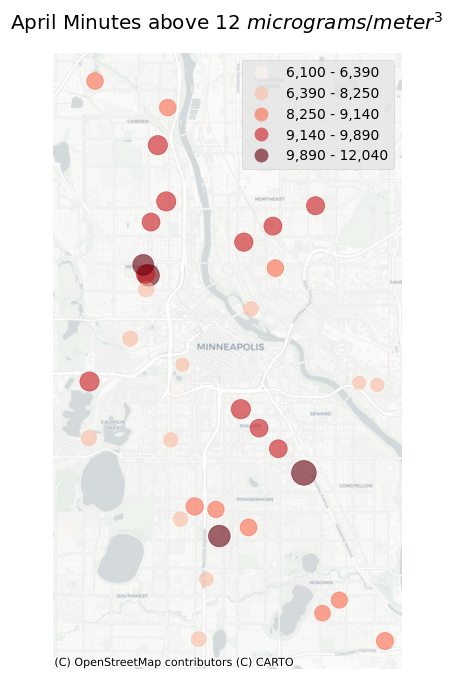

In [116]:
f, ax = plt.subplots(1, figsize = (10,8))

stat = 'pm25_fullDay_minutesAbove12ug'

art = select_sensors_gdf.plot(column = stat,
                        cmap = 'Reds',
                        k = 5,
                        s = (select_sensors_gdf[stat]/max(select_sensors_gdf[stat]) * 10)**2.5,
                        alpha = 0.6, 
                        scheme = 'Natural_Breaks', # Classification scheme
                        legend = True,
                       ax = ax)

# Clean up legend

leg = art.get_legend()
# leg._loc = 3

for lbl in leg.get_texts():
    label_text = lbl.get_text()
    lower = label_text.split(', ')[0]
    upper = label_text.split(', ')[1]
    new_text = f'{float(lower):,.0f} - {float(upper):,.0f}'
    lbl.set_text(new_text)

# Title

ax.set_title("April Minutes above 12 $micrograms/meter^3$")

# Add basemap

contextily.add_basemap(
            ax,
            crs=select_sensors_gdf.crs,
            source=contextily.providers.CartoDB.Positron
        )

# Remove axes

ax.set_axis_off()

plt.savefig('Minutes_Above.png', dpi = 300)

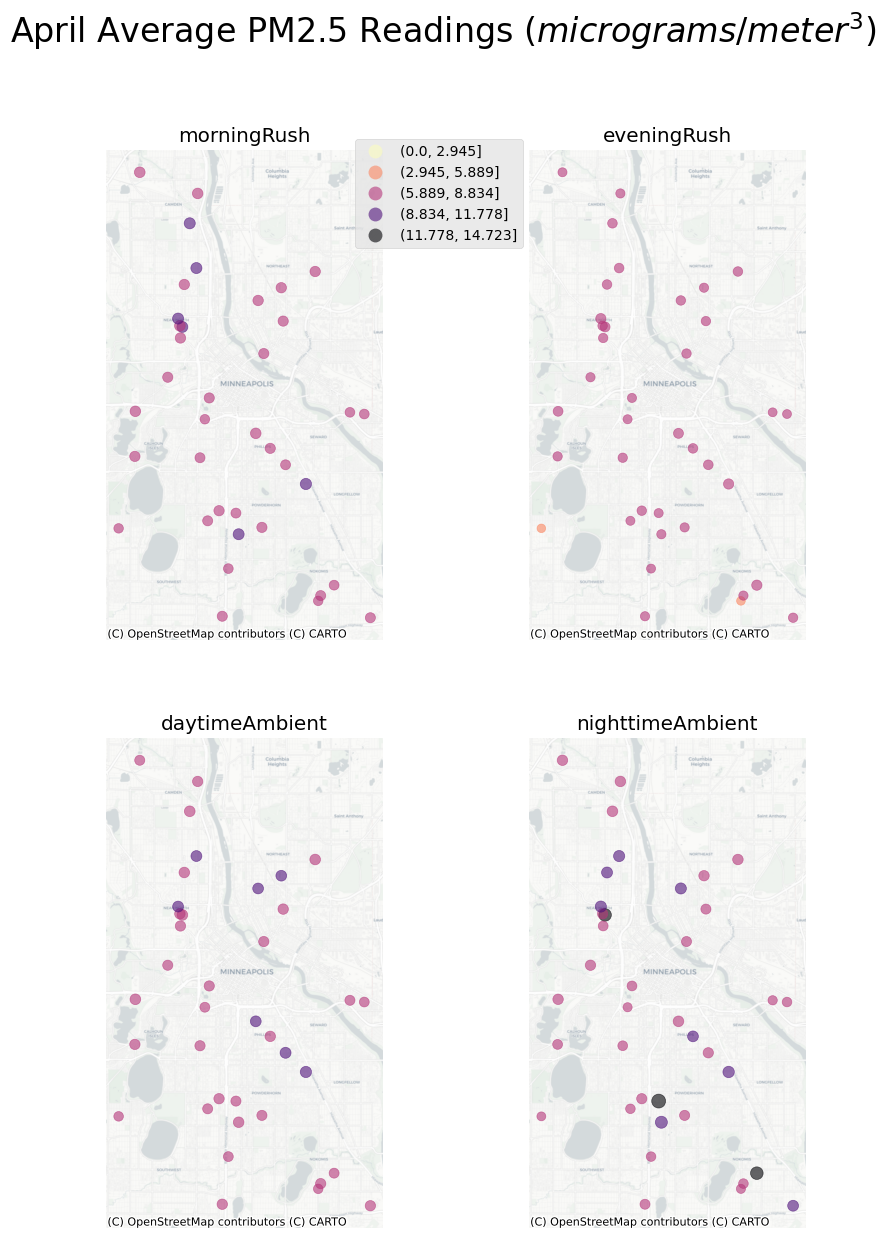

In [115]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors


times = ['morningRush','eveningRush',
         'daytimeAmbient', 'nighttimeAmbient']

statnames = ['pm25_' + time + '_mean' for time in times]

f, axs = plt.subplots(2,2, figsize = (10,14))

# Sup title 

f.suptitle("April Average PM2.5 Readings ($micrograms/meter^3$)",
          fontsize = 24)

# Work on classifications

n_categories = 5

max_val = max(select_sensors_gdf[statnames].max())
binwidth = max_val/n_categories
breaks = np.arange(0,max_val+binwidth,binwidth)

cmap = 'magma_r'

for i, ax in enumerate(axs.flatten()):
    
    ax.set_title(times[i])
    
    stat = 'pm25_' + times[i] + '_mean'
    
    binned_stat = pd.cut(select_sensors_gdf[stat], 
                         breaks)

    art = select_sensors_gdf.assign(
        statistic = binned_stat).plot(column = 'statistic',
                            cmap = cmap,
                            k = n_categories,
                            s = (select_sensors_gdf[stat]/max_val) * 100,
                            alpha = 0.6,
                            legend = True,
                           ax = ax)

    # Add basemap

    contextily.add_basemap(
                ax,
                crs=select_sensors_gdf.crs,
                source=contextily.providers.CartoDB.Positron
            )

    # Remove axes

    ax.set_axis_off()
    
    # Fix Legend
    
    leg = art.get_legend()
    
    if i == 0:
        
        leg._loc = (0.9, .8)
        # Create the global legend
        # Clean up legend

        # leg._loc = 3

#         for lbl in leg.get_texts():
#             label_text = lbl.get_text()
#             lower = label_text.split(', ')[0]
#             upper = label_text.split(', ')[1]
#             new_text = f'{float(lower):,.0f} - {float(upper):,.0f}'
#             lbl.set_text(new_text)
            
    else: # Remove
        leg.remove()
    
# f.tight_layout()

plt.savefig('AprilAverages.png', dpi = 300)

## Checking out the Max Times

In [178]:
good_ids = select_sensors.sensor_index

good_obs = select_obs[select_obs.sensor_index.isin(good_ids)]

print(len(good_ids))

38


pm25_fullDay_maxTime


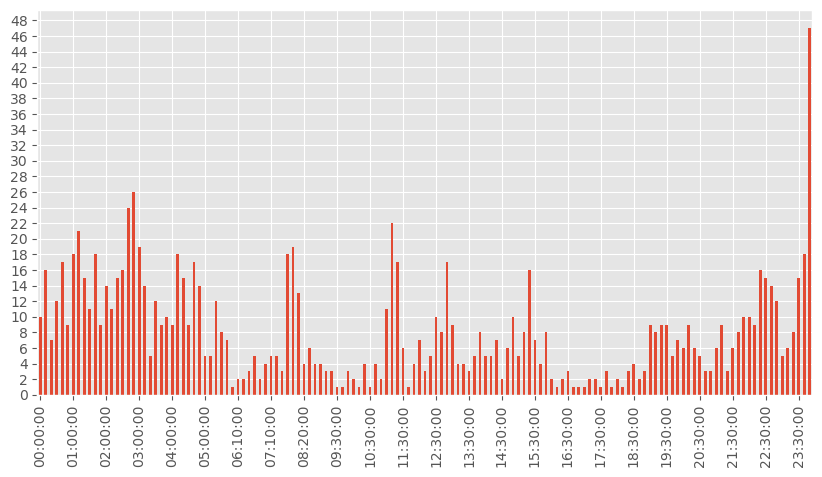



~~~~~~~

pm25_morningRush_maxTime


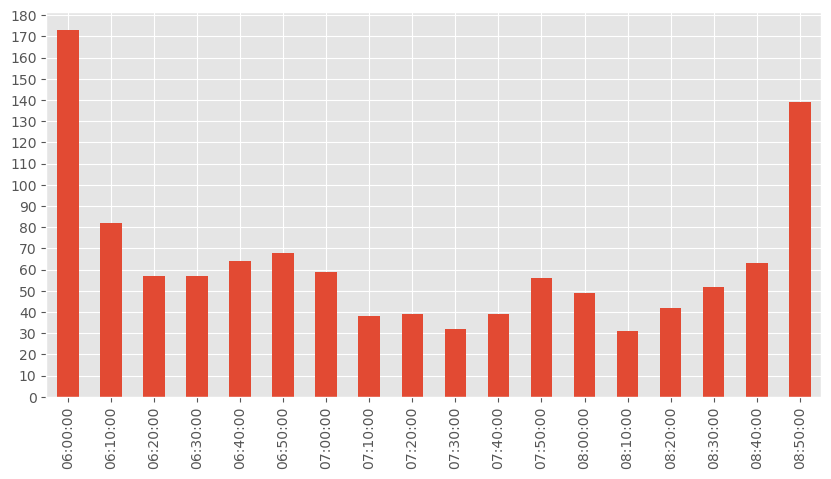



~~~~~~~

pm25_eveningRush_maxTime


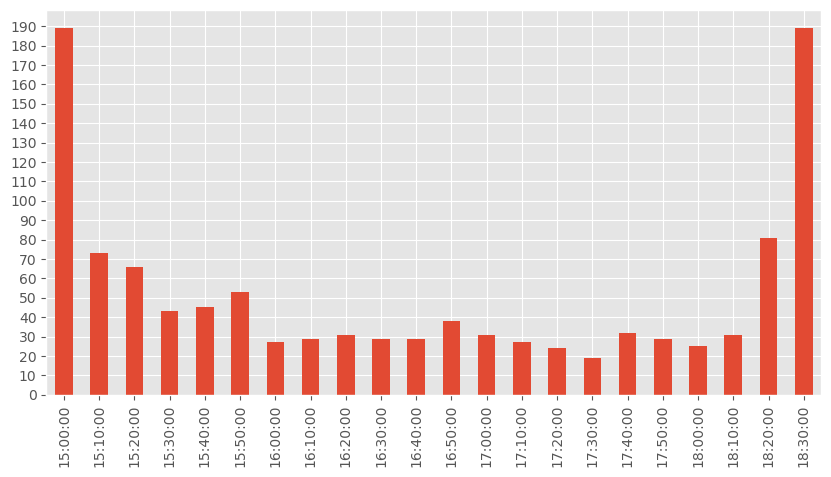



~~~~~~~

pm25_daytimeAmbient_maxTime


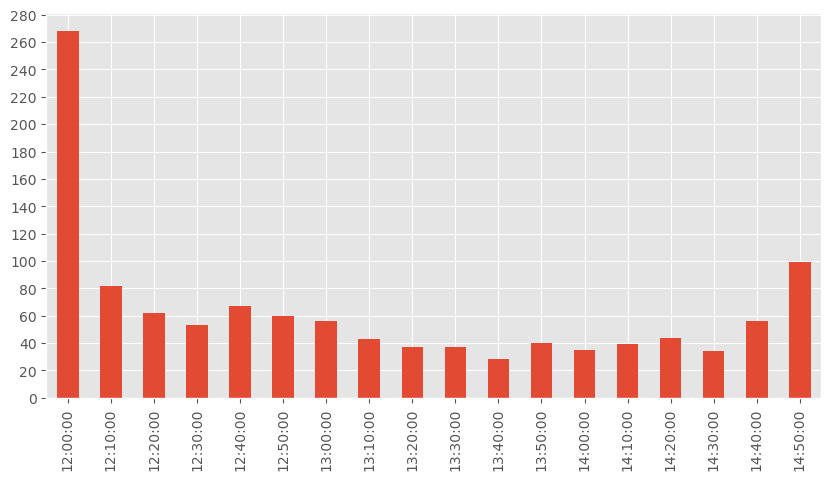



~~~~~~~

pm25_nighttimeAmbient_maxTime


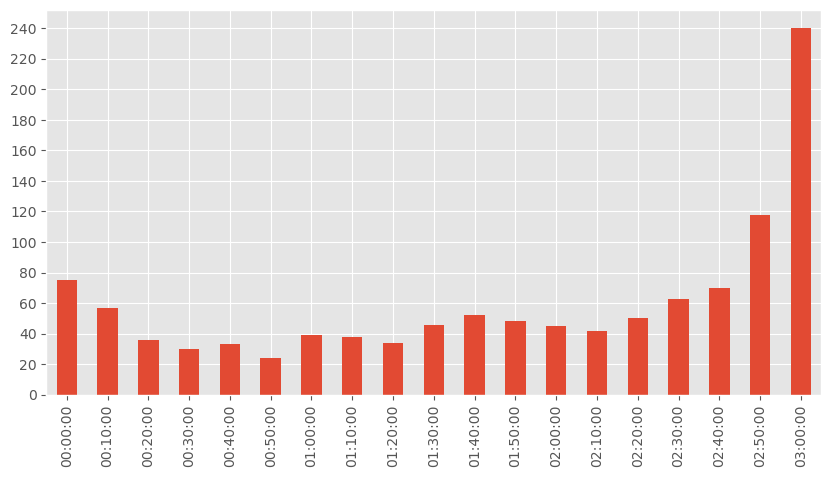



~~~~~~~



In [183]:
for time in ['fullDay'] + times:
    
    col_name = 'pm25_' + time + '_maxTime'

    f, ax = plt.subplots(1, figsize = (10, 5))
    
    print(col_name)
    
    dt_col = pd.to_datetime(good_obs[col_name])

    col_to_plot = dt_col.dt.time
    
    # xticks = pd.date_range(start = min(dt_col), 
    #                      end = max(dt_col),
    #                     freq = 'H').time

    col_to_plot.value_counts().sort_index().plot(kind='bar')
    
    plt.locator_params(nbins = 25)
    
    plt.show()
    print('\n\n~~~~~~~\n')

pm25_fullDay_maxTime


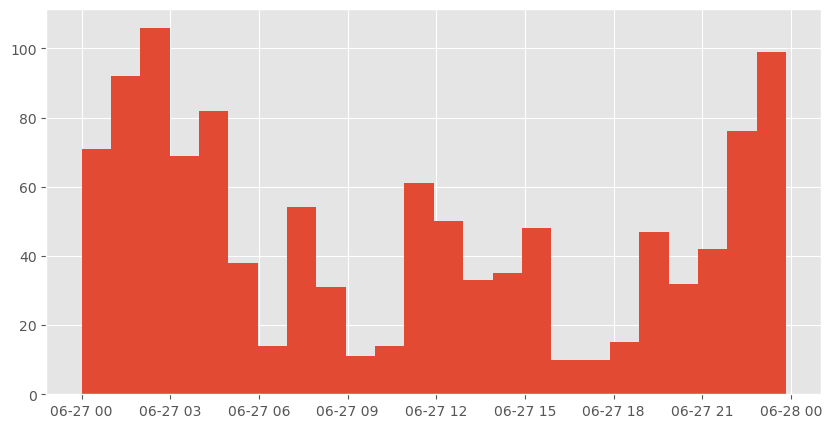



~~~~~~~

pm25_morningRush_maxTime


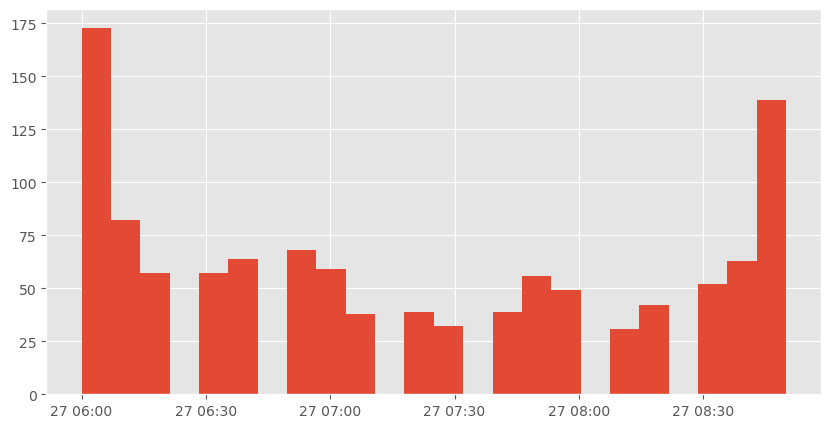



~~~~~~~

pm25_eveningRush_maxTime


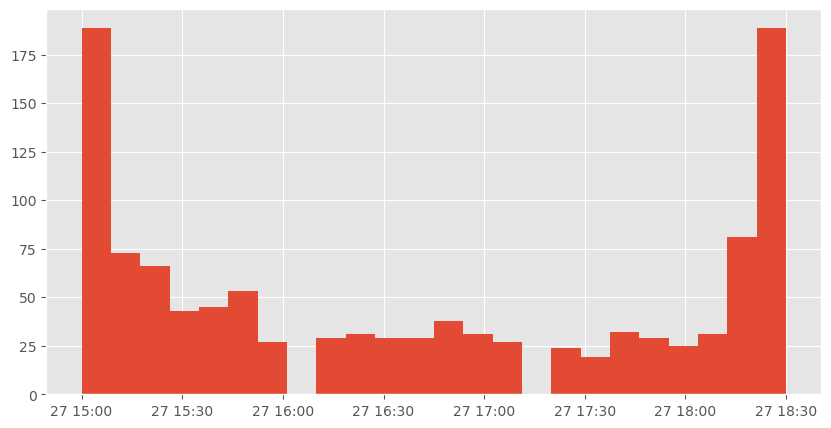



~~~~~~~

pm25_daytimeAmbient_maxTime


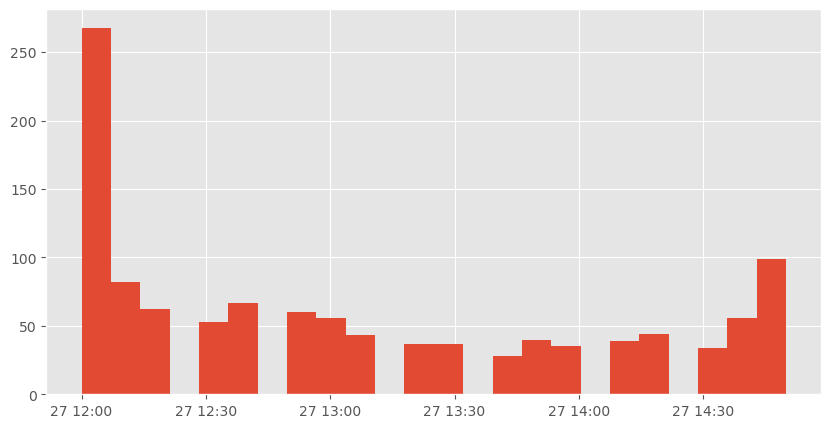



~~~~~~~

pm25_nighttimeAmbient_maxTime


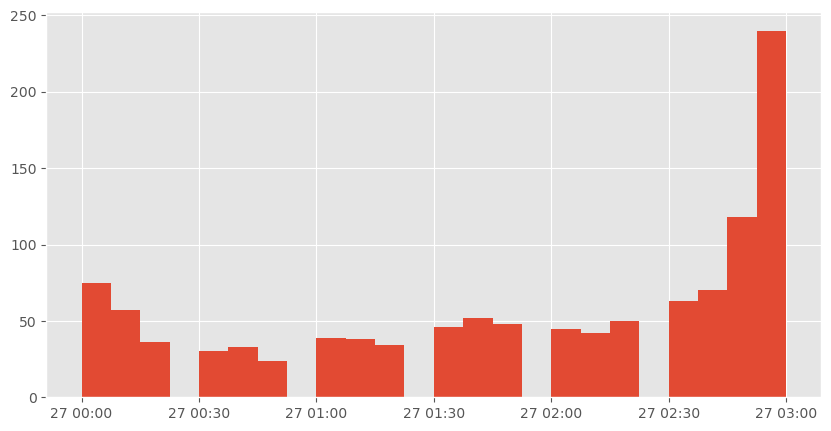



~~~~~~~



In [177]:
for time in ['fullDay'] + times:
    
    col_name = 'pm25_' + time + '_maxTime'

    f, ax = plt.subplots(1, figsize = (10, 5))
    
    print(col_name)
    
    dt_col = pd.to_datetime(good_obs[col_name])

    col_to_plot = dt_col.dt.time
    
    # xticks = pd.date_range(start = min(dt_col), 
    #                      end = max(dt_col),
    #                     freq = 'H').time

    dt_col.hist(bins = 24)
    
    # plt.locator_params(nbins = 8)
    
    plt.show()
    print('\n\n~~~~~~~\n')